In [1]:
from pathlib import Path
import json
from src.data_structures import Instance
from src.solvers import ZeroReductor,BaldoML,BaldoGA
from random import shuffle
import pandas as pd
from src.Gurobi import gurobi,SolverConfig,VAR_TYPE
from IPython.display import clear_output
import os
from matplotlib import pyplot as plt
import numpy as np

/usr/lib/python3.11/site-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /build/python-pytorch/src/pytorch-opt/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [2]:
results_path = Path("final_results")
baldo_data_path = Path("baldo_test_data")
files = results_path.iterdir()
names_to_use = [file.name for file in files]
instances = [] 
for file in names_to_use:
    instance = Instance.from_file(baldo_data_path/file)
    instance.file_name = file
    instances.append(instance)
instances.sort(key=lambda x: x.n_items)

In [3]:
for instance in instances:
    result = open(results_path/instance.file_name,"r")
    result_data = json.load(result)
    result.close()
    instance.result = result_data

In [24]:
ga_points = []
z_points = []
ml_points = []
final_results = Path("final_results")
for instance in instances:
    if instance.result['Solver_of'] == -1 or instance.result['BaldoML_of'] == -1 or instance.result['BaldoGA_of'] == -1 :
        continue
    if instance.n_items < 300:
        continue
    solver_time = instance.result["Solver_time"] + 1
    solver_of = instance.result["Solver_of"]
    gap = lambda instance,x: ((instance.result["Solver_of"]-instance.result[x])/instance.result["Solver_of"])
    threshold = "0.05"
    if gap(instance,f"Z_threshold{threshold}_of") > 0.06:
        print(instance.file_name)
    ga_points.append(
        (gap(instance,"BaldoGA_of"),
         (instance.result["BaldoGA_time"])/solver_time))
    if gap(instance,f"Z_threshold{threshold}_of") > 1000:
        print(instance.file_name)
    z_points.append(
        (gap(instance,f"Z_threshold{threshold}_of"),
         ( instance.result[f"Z_threshold{threshold}_time"]) / solver_time))
    ml_points.append(
        (gap(instance,"BaldoML_of"),
         ( instance.result["BaldoML_time"]) / solver_time))

In [25]:
print("Z_time",np.average([instance.result[f"Z_threshold{threshold}_time"] for instance in instances]))
print("BaldoML_time",np.average([instance.result["BaldoML_time"] for instance in instances]))
print("BaldoGA_time",np.average([instance.result["BaldoGA_time"] for instance in instances]))
print("GA_of",np.average([point[0] for point in ga_points])*100)
print("BaldoML_ml",np.average([point[0] for point in ml_points])*100)
print("Z_of",np.average([point[0] for point in z_points ])*100)

Z_time 2.945684682355128
BaldoML_time 16.735705774186016
BaldoGA_time 5.862004378068515
GA_of 3.447135687616792
BaldoML_ml 0.04488041568219285
Z_of 1.1008713887984234


1.1008713887984234


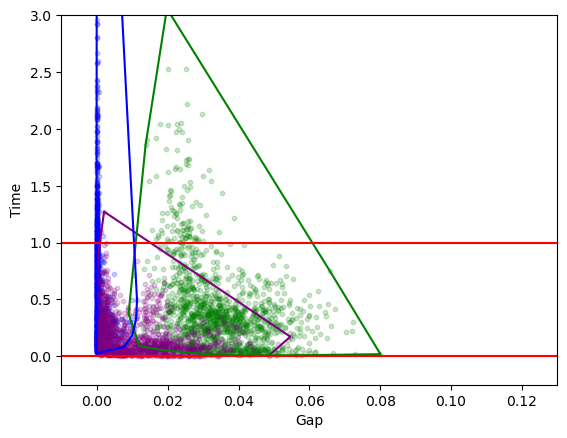

In [26]:
from shapely.geometry import Polygon,MultiPoint

def get_polygon(points):
    z_multipoint = MultiPoint(points)
    convex_hull = z_multipoint.convex_hull
    z_multipoint = convex_hull.exterior.xy
    return z_multipoint
plt.clf()
plt.plot(*get_polygon(z_points),color="purple")
plt.plot(*get_polygon(ga_points),color="green")
plt.plot(*get_polygon(ml_points),color="blue")

plt.xlabel("Gap")
plt.ylabel("Time")
plt.xlim(-0.01,0.13)
plt.ylim(-0.25,3)

plt.scatter([point[0] for point in ga_points],[point[1] for point in ga_points], alpha=0.2,color = "green",s=10)
plt.scatter([point[0] for point in ml_points],[point[1] for point in ml_points], alpha=0.2, color = "blue",s=10)
plt.scatter([point[0] for point in z_points ],[point[1] for point in z_points],   alpha=0.2,color ="purple",s=10)
print(np.average([point[0] for point in z_points])*100)
plt.plot([-1,1],[1,1],color = "red")
plt.plot([-1,1],[0,0],color = "red")
plt.savefig("solver_comparison",dpi=600)

1589

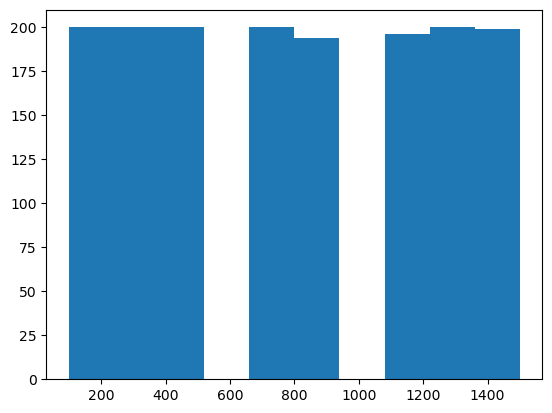

In [27]:
plt.hist([instance.n_items for instance in instances],bins=10)
len([instance.n_items for instance in instances])


(array([778., 273., 163.,  82.,  51.,  20.,   4.,   3.,   1.,   1.]),
 array([0.00135585, 0.12838853, 0.25542121, 0.38245389, 0.50948657,
        0.63651924, 0.76355192, 0.8905846 , 1.01761728, 1.14464996,
        1.27168264]),
 <BarContainer object of 10 artists>)

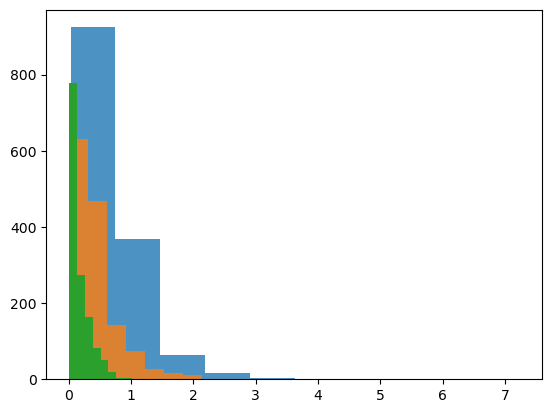

In [28]:
plt.hist([point[1] for point in ml_points] ,alpha = 0.8)
plt.hist([point[1] for point in ga_points] ,alpha = 0.8)
plt.hist([point[1] for point in z_points]  ,alpha = 1)

0.02980880138180892


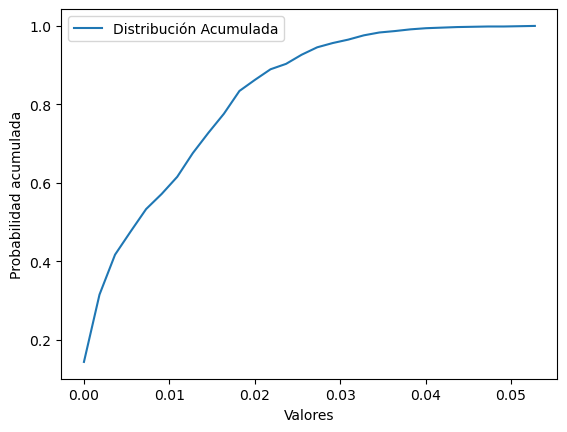

In [29]:

datos = [point[0] for point in z_points]
# Calcular el histograma
hist, bins = np.histogram(datos, bins=30, density=True)
percentil_999 = np.percentile(datos, 95)
print(percentil_999)
# Calcular la distribución acumulada
cdf = np.cumsum(hist * np.diff(bins))

# Graficar la distribución acumulada de manera continua
plt.plot(bins[:-1], cdf, label='Distribución Acumulada')
# Agregar etiquetas a los ejes
plt.title("")
plt.xlabel('Valores')
plt.ylabel('Probabilidad acumulada')
plt.legend()
